## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Application Example: Updating GMSL curve with your own data!

In this notebook, you can update the GMSL curve by [Walker et al., 2022](https://www.nature.com/articles/s41467-022-28564-6) with additional sea-level data by your choice!

In [1]:
# Installs the necessary pyro-ppl package as well as mounts the tutorial directory into google colab from drive so users can access the data directory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Install pyro-ppl
    %pip install pyro-ppl cartopy

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change directory
    %cd /content/drive/MyDrive/PaleoSTeHM/Tutorials/4.Applications
else:
    # Continue to the next cell
    pass

In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import sys
import os
import zipfile

sys.path.append('../..')
import PSTHM 
import time

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

### Loading relative sea-level data (provided by Walker et al., 2022)

- X: relative sea-level data age, latitude and longitude.
- y: GIA-signal corrected relative sea-level, assuming the GIA signal is linear based on ICE5G model.
- X sigma: age 1 sigma 
- y sigma: relative sea level reconstruction 1 sigma 
- cov_matrix: pre-trained data covariance matrix for Gaussian Process model

In [2]:
import pickle

# Load the dictionary from the file
with open('IFILES/X_y_data.pkl', 'rb') as file:
    data_dict = pickle.load(file)

X_all = torch.tensor(data_dict['X'])
y_no_GIA = torch.tensor(data_dict['y'])
noise_cov = torch.tensor(data_dict['data_cov'])
X_sigma = torch.tensor(data_dict['X_sigma'])
y_sigma = torch.tensor(data_dict['y_sigma'])

### Generate GMSL curve based on data from Walker et al., 2022

In [11]:
import pyro.contrib.gp as gp

# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.kernels.Matern32(input_dim=1,geo=False)
#define global temporal kernel slow
global_kernel_s = PSTHM.kernels.Matern32(input_dim=1,geo=False)

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = PSTHM.kernels.Linear(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(10.)))
regional_linear_temporal_kernel.ref_year = torch.tensor(2010.)

regional_linear_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_linear_kernel = PSTHM.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_kernel_f = PSTHM.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = PSTHM.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl_kernel_f = PSTHM.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = PSTHM.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)

s_whitenoise_kernel = PSTHM.kernels.WhiteNoise_SP(input_dim=1,sp=False,geo=True)

combined_sp_kernel = PSTHM.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_linear_kernel)

gpr = PSTHM.model.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)

pyro.get_param_store().load("IFILES/Walker_et_al_2022_GMSL_model.pt")


In [6]:
test_age = np.arange(-4000,2020,10)
#generate prediction for one location
data_point = X_all[2140,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1)

regional_linear_kernel = gpr.kernel.kern1
regional_nl_kernel =  gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


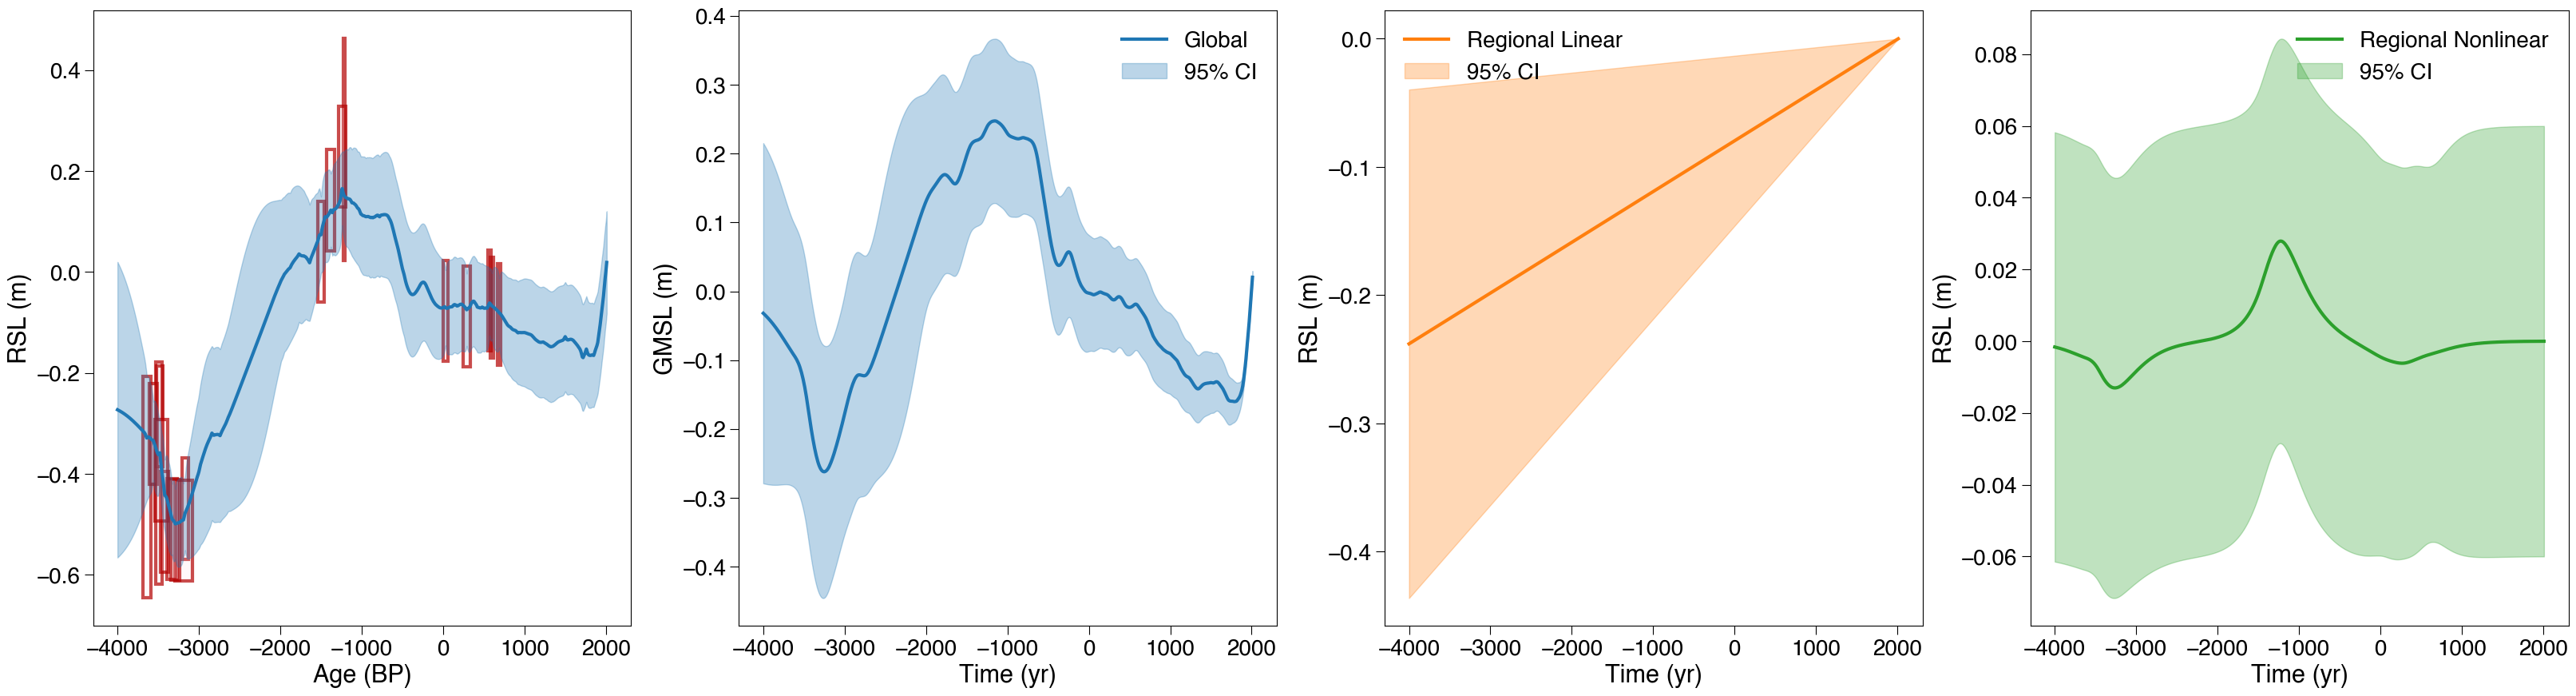

In [7]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs((X_all[:,1:]-data_point).detach().numpy()),axis=1)<1e-3
PSTHM.plotting.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

### Load you own data here and see what's the difference

Your data should have information about (i) RSL age, (ii) RSL, (iii) RSL 1 sigma uncertainty, (iv) RSL 1 sigma age uncertainty, (v) RSL longitude, (vi) RSL latitude for each data point. 

Here we will use diatom-based data from [Kirby et al., 2023](https://journals.sagepub.com/doi/full/10.1177/09596836231169992) collected at Ireland and see how does these new data impact on Common Era sea-level budget.

In [64]:
#load data
kirby_data = pd.read_excel('IFILES/Kirby et al. (2023).xlsx')
kirby_rsl_age = kirby_data['Age (CE)']
kirby_rsl_age_sigma = kirby_data['Age 2s']/2
kirby_rsl_lat = kirby_data['Latitude (°N)']
kirby_rsl_lon = kirby_data['Longitude (°E)']
kirby_rsl_lon[kirby_rsl_lon<0] += 360
kirby_X = np.hstack([kirby_rsl_age.values.reshape(-1,1),kirby_rsl_lat.values.reshape(-1,1),kirby_rsl_lon.values.reshape(-1,1)])
kirby_rsl = kirby_data['RSL (m)']
kirby_rsl_sigma = kirby_data['RSL 1s']

#remove GIA from kirby data
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]
#interpolate ICE5G linear rate to all sites
from scipy import interpolate
GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (kirby_rsl_lon, kirby_rsl_lat), method='linear')
kirby_y_no_GIA = kirby_rsl.copy()
kirby_y_no_GIA -=  GIA_rate*(kirby_rsl_age-2010)/1000

#merge new data with Walker et al., 2022
new_X = torch.vstack([X_all,torch.tensor(kirby_X)])
new_y_noGIA = torch.hstack([y_no_GIA,torch.tensor(kirby_y_no_GIA)])
new_noise = torch.zeros(new_y_noGIA.shape[0],new_y_noGIA.shape[0])
new_noise[:X_all.shape[0],:X_all.shape[0]] = noise_cov
new_noise[X_all.shape[0]:,X_all.shape[0]:] = torch.diag(torch.tensor(kirby_rsl_sigma)**2)
new_x_sigma = torch.hstack([X_sigma,torch.tensor(kirby_rsl_age_sigma)])
new_y_sigma = torch.hstack([y_sigma,torch.tensor(kirby_rsl_sigma)])

### Inputting new data into the model 

If you have quite a lot of new data, you can fine tune the model parameters according to your new data. Check other notebook for tuning model parameters.

In [88]:
import pyro.contrib.gp as gp

# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.kernels.Matern32(input_dim=1,geo=False)
#define global temporal kernel slow
global_kernel_s = PSTHM.kernels.Matern32(input_dim=1,geo=False)

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = PSTHM.kernels.Linear(input_dim=1)
regional_linear_temporal_kernel.ref_year = torch.tensor(2010.)

regional_linear_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_linear_kernel = PSTHM.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_kernel_f = PSTHM.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = PSTHM.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl_kernel_f = PSTHM.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = PSTHM.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)

s_whitenoise_kernel = PSTHM.kernels.WhiteNoise_SP(input_dim=1,sp=False,geo=True)

combined_sp_kernel = PSTHM.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_linear_kernel)
gpr = PSTHM.model.GPRegression_V(torch.tensor(new_X), torch.tensor(new_y_noGIA), combined_sp_kernel,noise=new_noise,jitter=1e-5)

pyro.get_param_store().load("IFILES/Walker_et_al_2022_GMSL_model.pt")


### Predict new Common Era GMSL curve

In [91]:
test_age = np.arange(-4000,2020,10)
#generate prediction for one location
data_point = gpr.X[-1,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1)

regional_linear_kernel = gpr.kernel.kern1
regional_nl_kernel =  gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean2,global_var2 = global_dep
global_std2 = global_var2.diag().sqrt()

regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean2,regional_nl_var2 = regional_nl_dep
regional_nl_std2 = regional_nl_var2.diag().sqrt()


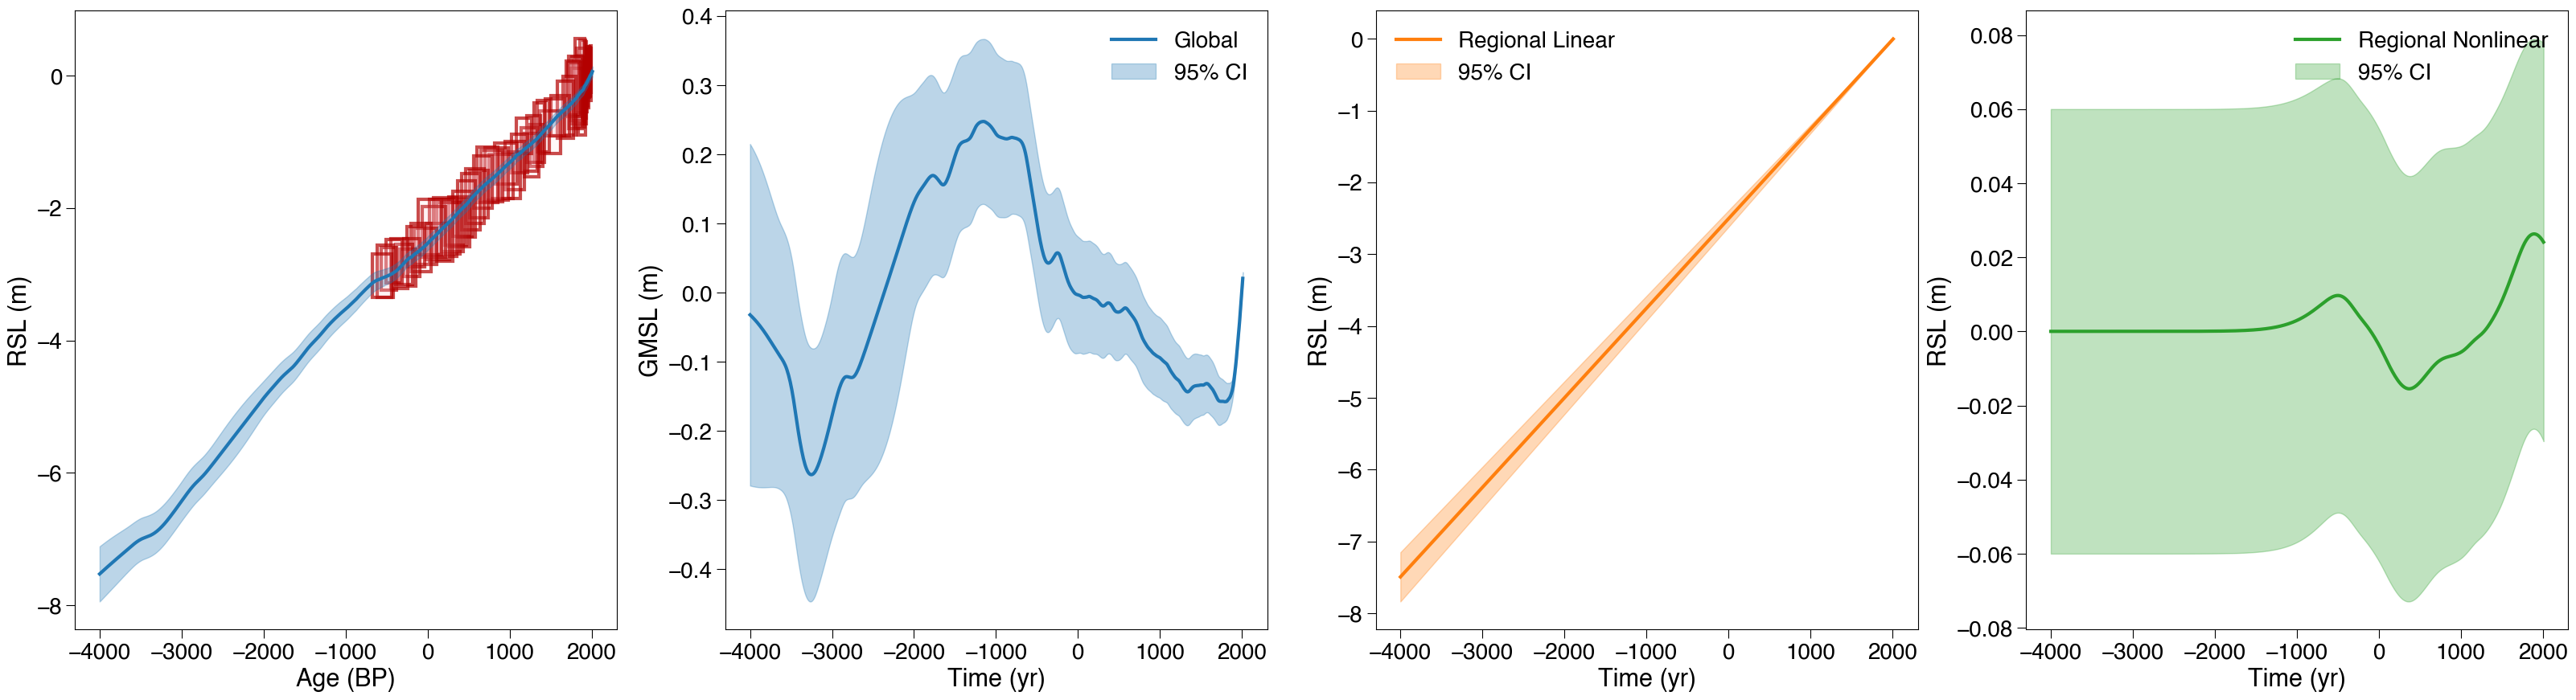

In [92]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs((gpr.X[:,1:]-data_point).detach().numpy()),axis=1)<1e-3
PSTHM.plotting.plot_uncertainty_boxes(gpr.X[:,0][data_index],gpr.y[data_index], new_x_sigma[data_index]*2,new_y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean2.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean2.detach().numpy()-2*global_std2.detach().numpy(),global_mean2.detach().numpy()+2*global_std2.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean2.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean2.detach().numpy()-2*regional_linear_std2.detach().numpy(),regional_linear_mean2.detach().numpy()+2*regional_linear_std2.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean2.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean2.detach().numpy()-2*regional_nl_std2.detach().numpy(),regional_nl_mean2.detach().numpy()+2*regional_nl_std2.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend();

### Compare new and old CE GMSL curve

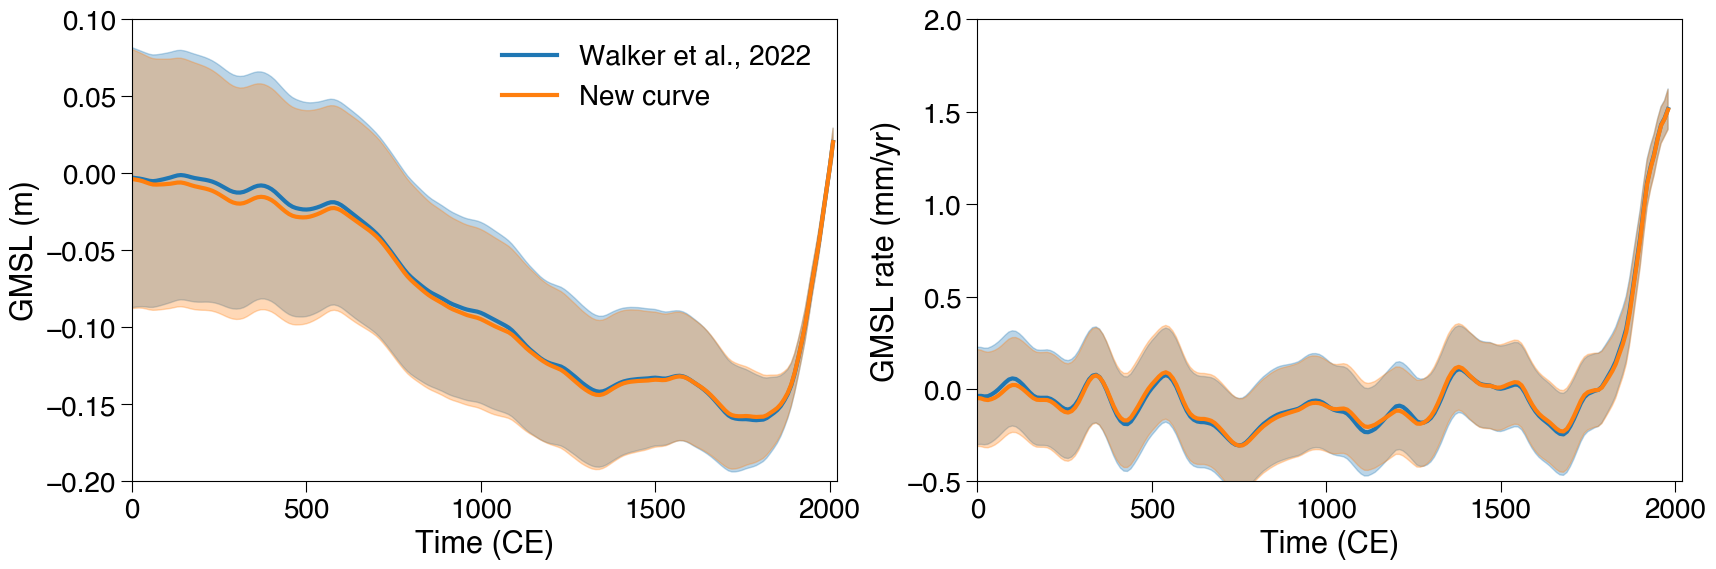

In [110]:

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Walker et al., 2022')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3)
plt.plot(test_age,global_mean2.detach().numpy(),'C1',linewidth=3,label='New curve')
plt.fill_between(test_age,global_mean2.detach().numpy()-2*global_std2.detach().numpy(),global_mean2.detach().numpy()+2*global_std2.detach().numpy(),color='C1',alpha=0.3)
plt.xlim(0,2020)
plt.ylim(-0.2,0.1)
plt.xlabel('Time (CE)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(122)
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy(),difftimestep=60)
rsl_time,rsl_rate2,rsl_rate_sd2 = PSTHM.post.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var2.detach().numpy(),global_mean2.detach().numpy(),difftimestep=60)
plt.plot(rsl_time,rsl_rate*1000,'C0',linewidth=3,label='Walker et al., 2022')
plt.fill_between(rsl_time,(rsl_rate-rsl_rate_sd)*1000,(rsl_rate+rsl_rate_sd)*1000,color='C0',alpha=0.3)
plt.plot(rsl_time,rsl_rate2*1000,'C1',linewidth=3,label='New curve')
plt.fill_between(rsl_time,(rsl_rate2-rsl_rate_sd2)*1000,(rsl_rate2+rsl_rate_sd2)*1000,color='C1',alpha=0.3)
plt.xlim(0,2020)
plt.ylim(-0.5,2)
plt.xlabel('Time (CE)')
plt.ylabel('GMSL rate (mm/yr)');

